## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [19]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

% matplotlib inline

def create_undist_coeff():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    calib_img = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     
        if calib_img is None:
            calib_img = gray

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
                   
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, calib_img.shape[::-1], None, None)
    return mtx, dist

mtx, dist = create_undist_coeff()

In [20]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

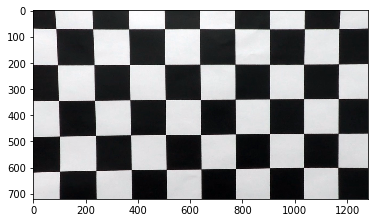

In [29]:
image_name = 'camera_cal/calibration1.jpg'
plt.imshow(undistort(cv2.imread(image_name), mtx, dist))

In [178]:
def normalize(array):
    return np.uint8(255 * array / np.max(array))

def apply_threshold(src, mask, threshold):
    mask[(src >= threshold[0]) & (src <= threshold[1])] = 1
    return mask

def threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    
    s_channel = normalize(hls[:, :, 2])
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    direction = np.arctan2(sobel_y, sobel_x)
    
    s_threshold = (90, 255)
    s_mask = apply_threshold(s_channel, np.zeros_like(gray), s_threshold)
    
    sobel_x_threshold = (30, 100)
    sobel_x = normalize(sobel_x)
    sobel_x_mask = apply_threshold(sobel_x, np.zeros_like(gray), sobel_x_threshold)
    
    sobel_y_threshold = (30, 100)
    sobel_y = normalize(sobel_y)
    sobel_y_mask = apply_threshold(sobel_y, np.zeros_like(gray), sobel_y_threshold)
    
    magnitude_threshold = (10, 100)
    magnitude = normalize(magnitude)
    magnitude_mask = apply_threshold(magnitude, np.zeros_like(gray), magnitude_threshold)
    
    direction_threshold = (0.7, 1.3)
    direction_mask = apply_threshold(direction, np.zeros_like(gray), direction_threshold)

    result = np.zeros_like(gray)
    result[(magnitude_mask == 1) & (direction_mask == 1)] = 1
    
    return result

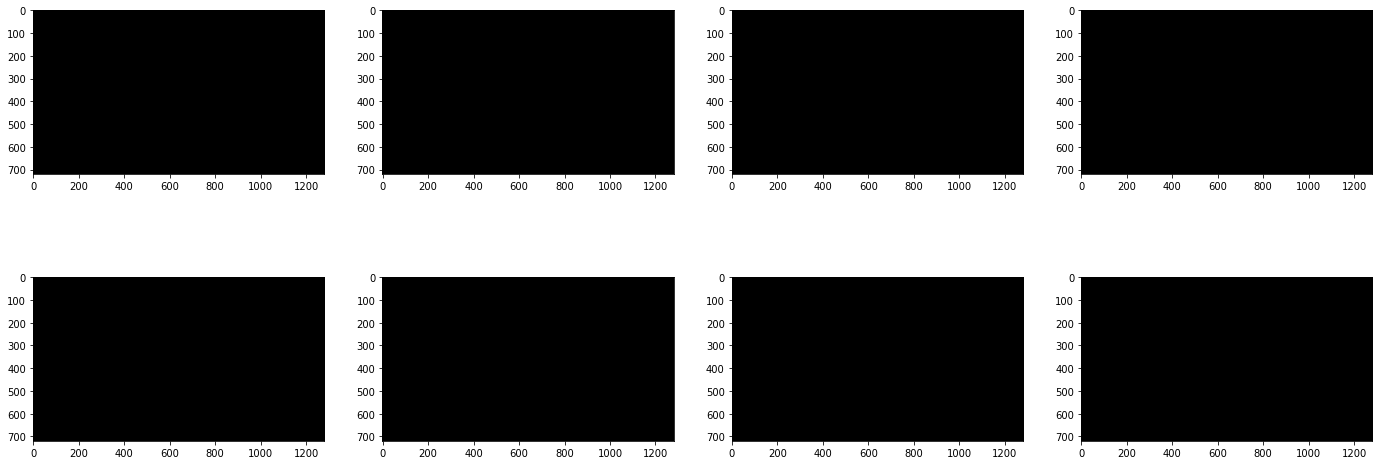

In [179]:
test_images = glob.glob('test_images/test*.jpg')
figure = plt.figure()
f, plots = plt.subplots(2, len(test_images) // 2, figsize=(24, 9))
plots = np.reshape(plots, [-1])
for i, name in enumerate(test_images):
    img = cv2.imread(name)
    plots[i].imshow(threshold(img), cmap='gray')